In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
btcusd_file_path = "../data/btcusd.csv"
data = pd.read_csv(btcusd_file_path)

data['time'] = pd.to_datetime(data['time'], unit='ms')

data = data.sort_values('time')
data = data.set_index('time')

data.head()
data.tail()
#data is 2013-04-01 to 2023-10-08

,open,close,high,low,volume
time,,,,,
2023-10-08 09:12:00,27924.0,27924.0,27924.0,27924.0,0.988912
2023-10-08 09:13:00,27931.0,27931.0,27931.0,27931.0,0.003000
2023-10-08 09:16:00,27935.0,27935.0,27935.0,27935.0,0.002700
2023-10-08 09:22:00,27934.0,27927.0,27935.0,27927.0,9.050877
2023-10-08 09:28:00,27912.0,27912.0,27912.0,27912.0,0.000442


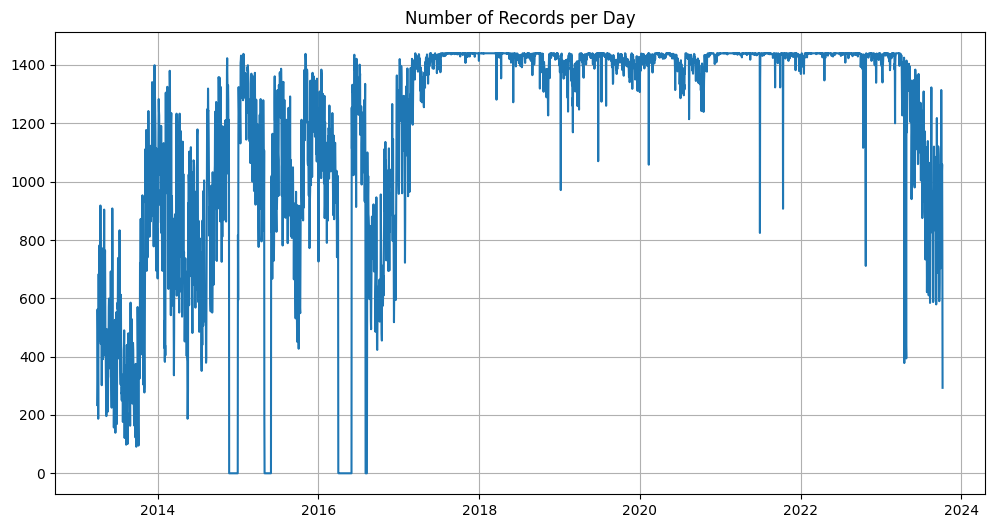

DatetimeIndex(['2014-11-22', '2014-11-23', '2014-11-24', '2014-11-25',
               '2014-11-26', '2014-11-27', '2014-11-28', '2014-11-29',
               '2014-11-30', '2014-12-01',
               ...
               '2016-05-29', '2016-05-30', '2016-05-31', '2016-08-03',
               '2016-08-04', '2016-08-05', '2016-08-06', '2016-08-07',
               '2016-08-08', '2016-08-09'],
              dtype='datetime64[ns]', name='time', length=137, freq=None)


In [3]:
# Calculate number of records per day
count = data['open'].resample('1D').apply(lambda x: x.count())

# Plot the number of records per day
plt.figure(figsize=(12, 6))
plt.plot(count)
plt.title('Number of Records per Day')
plt.grid()
plt.show()

zero_count = count[count == 0].index
print(zero_count)

#we might want to just start data from 2018-01-01
data = data['2018-01-01':]

In [4]:
# Calculate intraday log returns
data['Log Return'] = np.log(data['close'] / data['close'].shift(1))

# Drop records with missing log returns (the first record)
data.dropna(subset=['Log Return'], inplace=True)

# Calculate daily realized variance from log returns
rv_1d = data['Log Return'].resample('1D').apply(lambda x: np.sum(x**2))

# Normalise the realized variance by the number of intraday returns
count_1 = data['Log Return'].resample('1D').apply(lambda x: x.count())
rv_1d /= count_1

# Aggregate minute data into daily data:
daily_data = data.resample('1D').agg({
    'open': 'first',        # First open price of the day
    'close': 'last',        # Last close price of the day
    'high': 'max',          # Highest price of the day
    'low': 'min',           # Lowest price of the day
    'volume': 'sum',        # Total volume for the day
})

# Add daily realized variance and rename the column
daily_data['1D RV'] = rv_1d
daily_data.rename(columns={'1D RV': 'RV_d,t'}, inplace=True)

# Calculate daily returns from the daily close price
daily_data['daily_return'] = daily_data['close'].pct_change(fill_method=None)

# Drop records with missing daily returns (the first record)
daily_data.dropna(subset=['daily_return'], inplace=True)

# Normalise RV by the number of intraday returns, we are expecting 1440 a day
daily_data['RV_d,t'] *= 1440

daily_data.head()

,open,close,high,low,volume,"RV_d,t",daily_return
time,,,,,,,
2018-01-02,13375.0,14722.0,15500.000000,12795.0,56192.952729,0.005154,0.100628
2018-01-03,14717.0,15150.0,15428.830919,14500.0,38358.373452,0.003035,0.029072
2018-01-04,15150.0,15159.0,15422.157853,14060.0,46479.982643,0.003420,0.000594
2018-01-05,15159.0,16911.0,17105.000000,14725.0,54627.601065,0.002891,0.115575
2018-01-06,16912.0,17169.0,17252.000000,16251.0,29616.485248,0.002177,0.015256


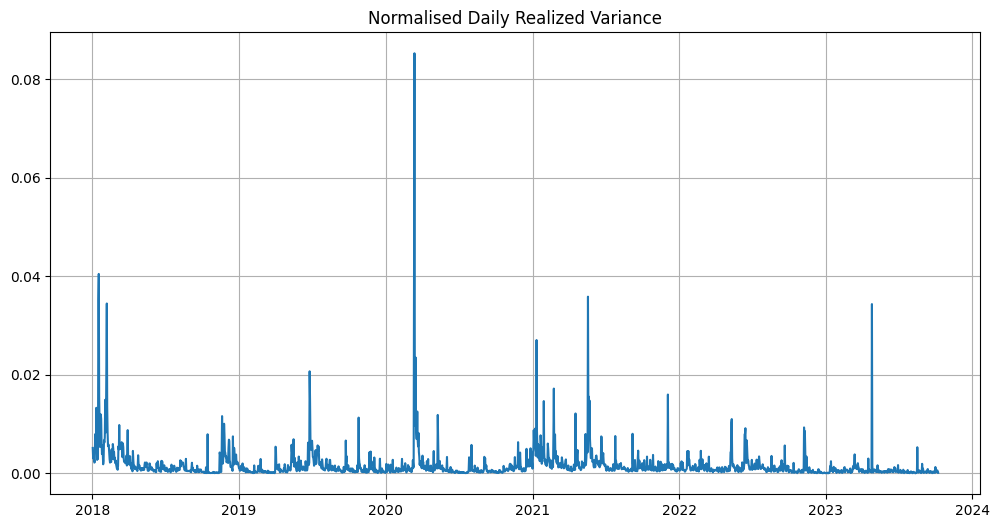

In [5]:
# Plot the daily realized variance
plt.figure(figsize=(12, 6))
plt.plot(daily_data['RV_d,t'])
plt.title('Normalised Daily Realized Variance')
plt.grid()
plt.show()

In [6]:
# Compute rolling averages for realized variance: 7-day and 30-day
daily_data['RV_w,t'] = daily_data['RV_d,t'].rolling(window=7).mean()
daily_data['RV_m,t'] = daily_data['RV_d,t'].rolling(window=30).mean()

# Apply logarithmic transformation to the realized variance measures
daily_data['ln_RV_d,t'] = np.log(daily_data['RV_d,t'])
daily_data['ln_RV_w,t'] = np.log(daily_data['RV_w,t'])
daily_data['ln_RV_m,t'] = np.log(daily_data['RV_m,t'])

# # Lag the daily, weekly, and monthly rv measures by one day
# daily_data['ln_RV_d,t-1'] = daily_data['ln_RV_d,t'].shift(1)
# daily_data['ln_RV_w,t-1'] = daily_data['ln_RV_w,t'].shift(1)
# daily_data['ln_RV_m,t-1'] = daily_data['ln_RV_m,t'].shift(1)
# # for the non-logarithmic RV measures as well
# daily_data['RV_d,t-1'] = daily_data['RV_d,t'].shift(1)
# daily_data['RV_w,t-1'] = daily_data['RV_w,t'].shift(1)
# daily_data['RV_m,t-1'] = daily_data['RV_m,t'].shift(1)

# Reset the index so that 'time' becomes a column again
daily_data = daily_data.reset_index()

# FRED MD Macro indicators

In [3]:
#from https://files.stlouisfed.org/files/htdocs/fred-md/monthly/current.csv
fred = pd.read_csv("../data/fred.csv")
fred.columns = fred.columns.str.strip()

# Convert 'sasdate' to datetime
fred["sasdate"] = pd.to_datetime(fred["sasdate"], errors="coerce")

# Remove the sasdate rows with NaT
fred = fred.dropna(subset=["sasdate"])
fred = fred[fred["sasdate"].dt.year >= 2018]

# Crypto Market Fear and Greed Index data

- source: https://www.kaggle.com/datasets/adilbhatti/bitcoin-and-fear-and-greed?resource=download
- index is constructed from news sentiment of different sources including:
    - Volatility (25 %)

        We’re measuring the current volatility and max. drawdowns of bitcoin and compare it with the corresponding average values of the last 30 days and 90 days. We argue that an unusual rise in volatility is a sign of a fearful market.

        This will cause some multicollinearity in the inputs, which may not necessarily affect model performance but may affect model interpretability. We aren't sure if the other components of this index are useful features, but this is the most straightforward way to incorporate market sentiment into our model without overcomplicating the endeavour.


    - Market Momentum/Volume (25%)
        
        When we see high buying volumes in a positive market on a daily basis, we conclude that the market acts overly greedy / too bullish.


    - Twitter Sentiment analysis (15%)



    - Bitcoin Dominance (10%)
        
        A rise in Bitcoin dominance is caused by a fear of (and thus a reduction of) too speculative alt-coin investments. When Bitcoin dominance shrinks, people are getting more greedy by investing in more risky alt-coins.


    - Google search trends (10%)

In [8]:
# https://www.kaggle.com/datasets/adilbhatti/bitcoin-and-fear-and-greed?resource=download
fear_greed = pd.read_csv("../data/fear_greed.csv")
fear_greed.columns = fear_greed.columns.str.strip()
print(fear_greed.columns)
fear_greed['Date'] = pd.to_datetime(fear_greed['Date'])
#drop  'BTC_Closing', 'BTC_Volume'
fear_greed.drop(columns=['BTC_Closing', 'BTC_Volume'], inplace=True)
#backfill missing values
fear_greed.fillna(method='bfill', inplace=True)
#rename
fear_greed.rename(columns={'Value': 'Fear_Greed_Value', 'Value_Classification': 'Fear_Greed_Classification'}, inplace=True)

Index(['Date', 'Value', 'Value_Classification', 'BTC_Closing', 'BTC_Volume'], dtype='object')


In [9]:
#merge all three dataframes
daily_data['month_year'] = pd.to_datetime(daily_data['time']).dt.to_period('M')
fred['month_year'] = fred['sasdate'].dt.to_period('M')

# Merge the data using the helper column 'month_year'
daily_data = pd.merge(daily_data, fred, on='month_year', how='inner')

# Drop the helper column 'month_year'
daily_data.drop(columns='month_year', inplace=True)

daily_data = daily_data.merge(fear_greed, how='inner', left_on='time', right_on='Date')

#drop 'sasdate', 'Date'
daily_data.drop(columns=['sasdate', 'Date'], inplace=True)

#how many dates between 2018-02-01 00:00:00 and 2023-03-31 00:00:00
print(len(pd.date_range(start='2018-02-01', end='2023-03-31', freq='D'))) #1885 is correct
daily_data.to_csv("../data/btcusd_processed.csv", index=False)

1885


# Feature Selection-- LASSO

In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.model_selection import TimeSeriesSplit


# exclude warnings
import warnings
warnings.filterwarnings('ignore')
data = pd.read_csv("../data/btcusd_processed.csv")


data = data.dropna()
# exclude all RV measures and non-numeric columns
to_exclude = ['time', 'daily_return', 'ln_RV_d,t', 'ln_RV_w,t', 'ln_RV_m,t', 'RV_d,t', 'RV_w,t', 'RV_m,t' ,'Fear_Greed_Classification']
features = [col for col in data.columns if col not in to_exclude]  # Exclude time & target

# train test split 80/20
train_size = int(len(data) * 0.8)
train = data.iloc[:train_size]
test = data.iloc[train_size:]

X = train[features].values[:-1]
#predicting next day's realized variance which is leading by 1 day
y = train['ln_RV_d,t'].shift(-1).values[:-1]

In [24]:
# Standardize Features
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Define time-series split (e.g., 5 splits, expanding window)
tscv = TimeSeriesSplit(n_splits=5)

lasso = LassoCV(
    alphas=np.logspace(-5, 1, 50), 
    cv=tscv,  # Use time series CV
    max_iter=10000,
    tol=1e-4,
    random_state=41
).fit(X_scaled, y_scaled)


print(lasso.coef_)
# Select Important Features
selected_features = np.array(features)[lasso.coef_ != 0]  # Keep non-zero coefficients
print(f"Selected {len(selected_features)} features: {selected_features}")

# Create a New Dataset with Selected Features
data_selected = data[to_exclude + list(selected_features) + ['Fear_Greed_Value']]
data_selected.to_csv("../data/btcusd_lasso_selected.csv", index=False)

print("Feature selection complete! Saved dataset with important features.")

[ 0.          0.          0.06346841  0.          0.36833712  0.
  0.          0.          0.          0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
  0.         -0.         -0.         -0.          0.          0.
  0.          0.         -0.         -0.01584873  0.04465015  0.
 -0.         -0.         -0.          0.         -0.         -0.
 -0.         -0.          0.         -0.         -0.          0.
 -0.         -0.         -0.         -0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.11287039 -0.          0.          0.         -0.
  0.         -0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.
  0.         -0.          0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
  0.         -0.05359219 

Selected features are: ['high' 'volume' 'IPFINAL' 'UEMP15T26' 'UEMP27OV' 'PERMITW' 'TB3SMFFM'
 'EXSZUSx' 'EXJPUSx' 'VIXCLSx']

 Here’s what each one signifies:

IPFINAL - Industrial Production: Final Products (Market Group)

Measures the output of final goods (consumer and business equipment) produced by U.S. industries.
Part of the broader Industrial Production Index published by the Federal Reserve.


UEMP15T26 - Unemployed Persons: 15 to 26 Weeks

Tracks the number of unemployed individuals in the U.S. who have been without work for 15 to 26 weeks.
Indicator of medium-term unemployment trends.


UEMP27OV - Unemployed Persons: 27 Weeks and Over

Measures long-term unemployment (people unemployed for 27 weeks or more).
A crucial labor market indicator used to assess economic downturns and prolonged joblessness.


PERMITW - New Private Housing Units Authorized by Building Permits in the West Census Region

Tracks building permits issued for private housing construction in the Western U.S..
An important leading indicator of housing market activity.


TB3SMFFM - 3-Month Treasury Bill Minus Federal Funds Rate (Monthly)

The spread between the 3-month Treasury Bill rate and the Federal Funds Rate.
Used as an indicator of monetary policy stance and liquidity conditions.


EXSZUSx - Switzerland / U.S. Foreign Exchange Rate

The exchange rate of the Swiss Franc (CHF) to the U.S. Dollar (USD).
Reflects trends in international trade, currency strength, and monetary policy differences.


EXJPUSx - Japan / U.S. Foreign Exchange Rate

The exchange rate of the Japanese Yen (JPY) to the U.S. Dollar (USD).
Used for analyzing U.S.-Japan trade relations and currency fluctuations.


VIXCLSx - CBOE Volatility Index (VIX), Close Price

Commonly known as the “Fear Index”, it measures the expected volatility of the S&P 500 over the next 30 days.
Higher values indicate increased market uncertainty and risk aversion


Crypto fear and greed index was not selected but i want to include this anyway